<a href="https://colab.research.google.com/github/GWANGHYUNYU/pytorch-tutorial/blob/master/10_1_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
# Lab 11 MNIST and Convolutional Neural Network
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [81]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 8

In [82]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [83]:
trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
Train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
Test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [85]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [86]:
dataiter = iter(Test_dataloader)
images, labels = dataiter.next()

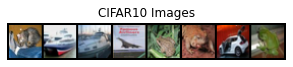

In [94]:
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("CIFAR10 Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images, padding=2, normalize=True),(1,2,0)))

In [95]:
def imshow(img, labels):
    # xlabels = []
    # for i in range(len(labels)):
    #     xlabels.append(classes[labels[i]])
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    row, _, __, ___ = img.size()
    for i in range(len(npimg)):
        plt.subplot(1,row,i+1)
        plt.imshow(np.transpose(npimg[i], (1, 2, 0)))
        plt.title(classes[labels[i]])  # 제목 추가
        plt.axis("off")  # 축 제거
    plt.show()

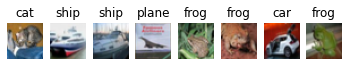

In [96]:
imshow(images, labels)

In [136]:
class CNN_basic_style(torch.nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(CNN_basic_style, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64 * 8 * 8, num_classes)
        self.pool = torch.nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # print("연산 전", x.size())
        x = F.relu(self.conv1(x))
        # print("conv1 연산 후", x.size())
        x = self.pool(x)
        # print("max_pool 연산 후", x.size())
        x = F.relu(self.conv2(x))
        # print("conv2 연산 후", x.size())
        x = self.pool(x)
        # print("max_pool 연산 후", x.size())
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        # print("fc1 연산 후", x.size())
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [137]:
net = CNN_basic_style()
output = net(images).to(device)

In [112]:
# CNN Model (2 conv layers)
class CNN_Sequential_style(torch.nn.Module):

    def __init__(self):
        super(CNN_Sequential_style, self).__init__()
        # L1 ImgIn shape=(?, 32, 32, 3)
        #    Conv     -> (?, 32, 32, 32)
        #    Pool     -> (?, 16, 16, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 16, 16, 32)
        #    Conv      ->(?, 16, 16, 64)
        #    Pool      ->(?, 8, 8, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # Final FC 8x8x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(8 * 8 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [116]:
# instantiate CNN model
model = CNN_Sequential_style().to(device)

In [126]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [130]:
file_name = 'CNN_Sequential_style_cifar10.pt'
# train my model
for epoch in range(1, training_epochs + 1):
    print("epoch: [%d/%d]" % (epoch, training_epochs + 1))

    model.train()

    for i, data in enumerate(tqdm(Train_dataloader)):
        images, labels = data[0].to(device), data[1].to(device)

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(model.state_dict(), './checkpoint/' + file_name)
    print('Model Saved!')

    correct = 0
    total = 0
    count = 0

    model.eval()
    for i, data in enumerate(Train_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # inputs, labels = data
        images, labels = data[0].to(device), data[1].to(device)

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(images)
        loss = criterion(outputs, labels)

        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print("LOSS: {}".format(loss.item()))
    print("Validating Accuracy of the model {} %".format(100 * correct / total))

    scheduler.step()
print('Finished Training')

  0%|          | 7/6250 [00:00<01:33, 66.60it/s]

epoch: [1/16]


100%|██████████| 6250/6250 [01:31<00:00, 68.02it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:39, 62.51it/s]

LOSS: 0.582895040512085
Validating Accuracy of the model 77.752 %
epoch: [2/16]


100%|██████████| 6250/6250 [01:35<00:00, 65.74it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:33, 66.63it/s]

LOSS: 1.0470467805862427
Validating Accuracy of the model 79.52 %
epoch: [3/16]


100%|██████████| 6250/6250 [01:35<00:00, 65.69it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:34, 66.12it/s]

LOSS: 0.7742131352424622
Validating Accuracy of the model 81.372 %
epoch: [4/16]


100%|██████████| 6250/6250 [01:34<00:00, 66.46it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:30, 68.82it/s]

LOSS: 0.37501850724220276
Validating Accuracy of the model 81.796 %
epoch: [5/16]


100%|██████████| 6250/6250 [01:34<00:00, 65.85it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:41, 61.57it/s]

LOSS: 0.7783605456352234
Validating Accuracy of the model 83.344 %
epoch: [6/16]


100%|██████████| 6250/6250 [01:34<00:00, 65.94it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:35, 65.30it/s]

LOSS: 0.7814105749130249
Validating Accuracy of the model 82.958 %
epoch: [7/16]


100%|██████████| 6250/6250 [01:35<00:00, 65.78it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:37, 63.71it/s]

LOSS: 0.22499291598796844
Validating Accuracy of the model 84.588 %
epoch: [8/16]


100%|██████████| 6250/6250 [01:35<00:00, 65.16it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:32, 67.25it/s]

LOSS: 0.2176942229270935
Validating Accuracy of the model 84.814 %
epoch: [9/16]


100%|██████████| 6250/6250 [01:36<00:00, 65.05it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:33, 66.60it/s]

LOSS: 0.2915728986263275
Validating Accuracy of the model 86.404 %
epoch: [10/16]


100%|██████████| 6250/6250 [01:37<00:00, 64.32it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:33, 66.42it/s]

LOSS: 0.2247917503118515
Validating Accuracy of the model 85.344 %
epoch: [11/16]


100%|██████████| 6250/6250 [01:38<00:00, 63.68it/s]


Model Saved!


  0%|          | 6/6250 [00:00<01:44, 59.84it/s]

LOSS: 0.37814998626708984
Validating Accuracy of the model 91.53 %
epoch: [12/16]


100%|██████████| 6250/6250 [01:35<00:00, 65.52it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:35, 65.18it/s]

LOSS: 0.18033087253570557
Validating Accuracy of the model 91.594 %
epoch: [13/16]


100%|██████████| 6250/6250 [01:35<00:00, 65.76it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:41, 61.24it/s]

LOSS: 0.045928940176963806
Validating Accuracy of the model 92.104 %
epoch: [14/16]


100%|██████████| 6250/6250 [01:35<00:00, 65.67it/s]


Model Saved!


  0%|          | 7/6250 [00:00<01:37, 63.81it/s]

LOSS: 0.07024110108613968
Validating Accuracy of the model 92.57 %
epoch: [15/16]


100%|██████████| 6250/6250 [01:38<00:00, 63.73it/s]


Model Saved!
LOSS: 0.4482453763484955
Validating Accuracy of the model 92.764 %
Finished Training


In [ ]:
file_name = 'CNN_basic_style_cifar10.pt'

best_valid_loss = float('inf')

# train my model
for epoch in range(1, training_epochs + 1):
    print("epoch: [%d/%d]" % (epoch, training_epochs + 1))

    net.train()

    for i, data in enumerate(tqdm(Train_dataloader)):
        images, labels = data[0].to(device), data[1].to(device)

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(images)
        loss = criterion(outputs, labels)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    correct = 0
    total = 0
    count = 0

    net.eval()
    for i, data in enumerate(Train_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # inputs, labels = data
        images, labels = data[0].to(device), data[1].to(device)

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(images)
        loss = criterion(outputs, labels)

        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print("LOSS: {}".format(loss.item()))
    print("Validating Accuracy of the model {} %".format(100 * correct / total))
    valid_loss = loss.item()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), file_name)
        print('Model Saved!')

    scheduler.step()
print('Finished Training')

  0%|          | 6/6250 [00:00<01:56, 53.73it/s]

epoch: [1/16]


 74%|███████▎  | 4603/6250 [01:16<00:28, 57.64it/s]

In [ ]:
# 학습된 모델 저장
from google.colab import files

files.download('CNN_basic_style_cifar10.pt')